# LLMOps with DeepEval

# 1. Overview
LLMOps covers:
1. **Testing**
2. **Evaluation**
3. **Monitoring**
4. Infrastructure
5. Orchestration
6. Deployment

We will discuss how to use the [DeepEval library](https://deepeval.com/) to help you with 1,2 and 3(ish).

Deepeval can help you with [end-to-end evaluations](https://deepeval.com/docs/evaluation-end-to-end-llm-evals) as in:

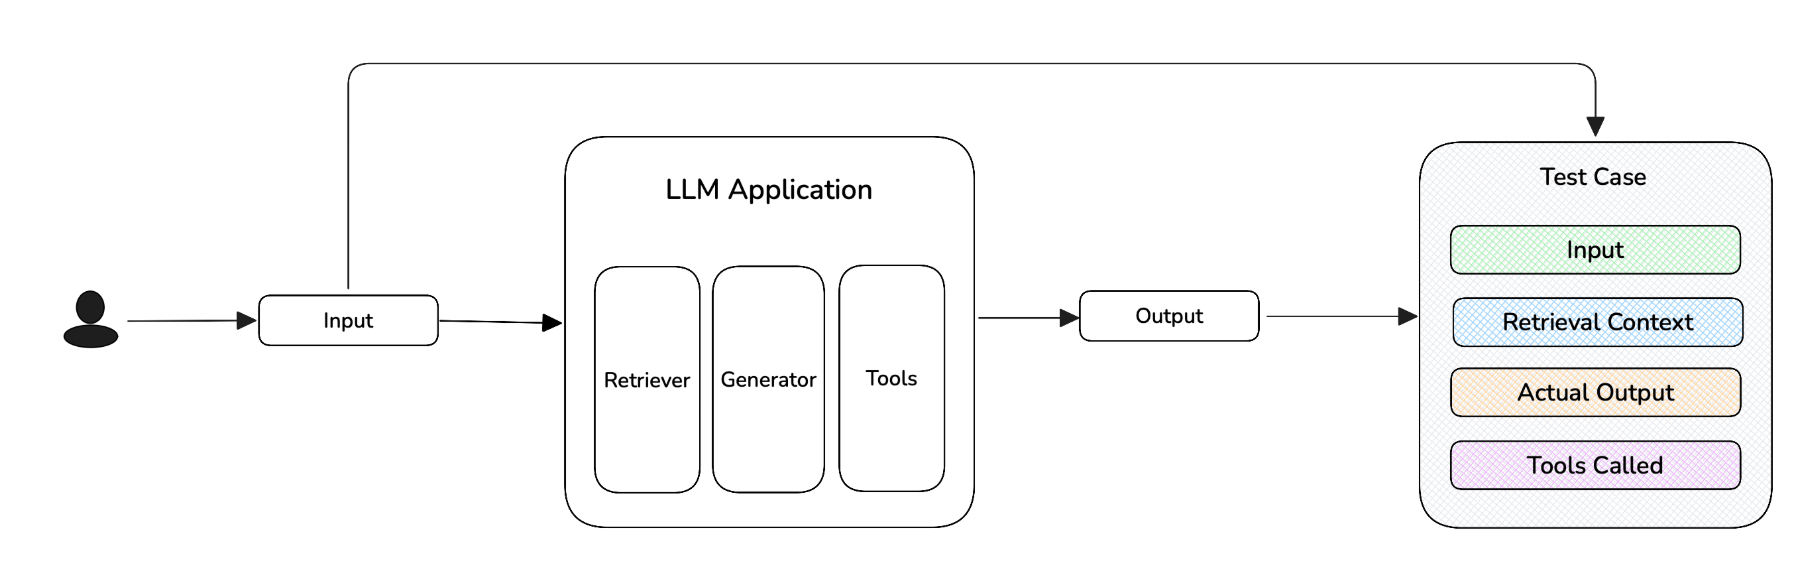

You can also use it for [tracing](https://deepeval.com/docs/evaluation-llm-tracing) and for [component level evals](https://deepeval.com/docs/evaluation-component-level-llm-evals) as in

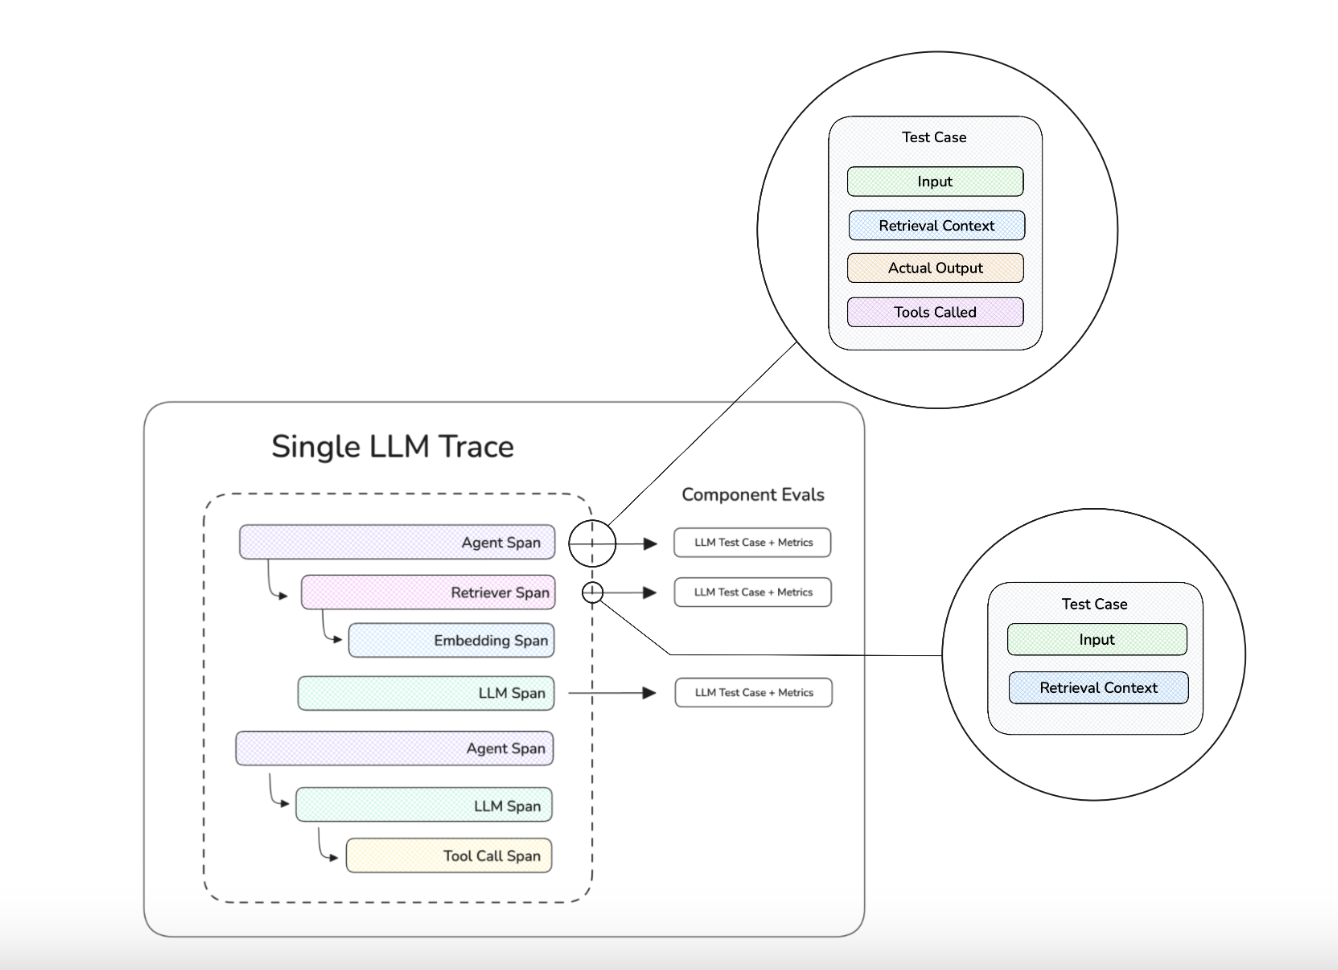


Rest of the talk:

2. **Main Concepts**
    1. `LLMTestCase` and `ConversationalTestCase`
    2.  Metrics and Test Execution
    3. `Golden`
    4. Datasets (`EvaluationDataset`)

3. **Example - RAG Agent**

4. **Execution (More Examples)**
    1. Unit test`deepeval test`
    2. Callback
    3. Batch

**Resources**
- https://github.com/confident-ai/deepeval/blob/main/examples/notebooks/langgraph.ipynb

In [ ]:
# HOUSEKEEPING
from dotenv import load_dotenv
import os
load_dotenv()
OPEN_API_KEY = os.environ["OPENAI_API_KEY"]

from IPython.core.magic import register_cell_magic
@register_cell_magic
def skip(line, cell):
    return

from pprint import pprint

# 2. Main Concepts
1. `LLMTestCase` and `ConversationalTestCase`
2.  Metrics and Test Execution
3. `Golden`
4. Datasets (`EvaluationDataset`)


## 2.1 `LLMTestCase` and `ConversationalTestCase`

In [ ]:
from deepeval.test_case import LLMTestCase

# Note: You're input is the actual input from the user/prompt, not your full prompt template.
test_case = LLMTestCase(
        input="I have a persistent cough and fever. Should I be worried?",
        # Replace this with the actual output from your LLM application
        actual_output="A persistent cough and fever could be a viral infection or something more serious. See a doctor if symptoms worsen or don't improve in a few days.",
        expected_output="A persistent cough and fever could indicate a range of illnesses, from a mild viral infection to more serious conditions like pneumonia or COVID-19. You should seek medical attention if your symptoms worsen, persist for more than a few days, or are accompanied by difficulty breathing, chest pain, or other concerning signs.",
        context=["The British Medical Association states that coughs are bad."], # --> The IDEAL retrieved context
        retrieval_context=[
            "According to Wikipedia, the Second Punic War was totally awesome for Hannibal.", 
            "The Brtish Medical Association said that flu is bad",
            "According to quantum field theory, the vaccum energy is non-zero due to field fluctuations and virtual particles"
        ]   
    )

In [ ]:
from deepeval.test_case import ConversationalTestCase, Turn

# Note: Annoyingly the "turns" are expected each as a single object, doesn't seem you can just pass a conversation history.
# This is similar to behaviour seen with test cases, where you have to create each individual test case in your set before evaluating.
conversational_test_case = ConversationalTestCase(
    scenario="User chit-chatting randomly with AI.",
    expected_outcome="AI should respond in friendly manner.",
    turns=[
        Turn(role="user", content="How are you doing?"),
        Turn(role="assistant", content="Why do you care?")
    ]
)

### 2.1.1 OpenAI Conversation API example

In [ ]:
%%skip
from openai import OpenAI
client = OpenAI()

# Response
items = client.conversations.items.list("conv_123", limit=10)
print(items.data)

### 2.1.2 Bedrock Converse API Example
Resources
- https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/bedrock-runtime/client/converse.html
- https://docs.aws.amazon.com/bedrock/latest/userguide/conversation-inference-examples.html

In [ ]:
%%skip
import boto3

bedrock_client = boto3.client(service_name='bedrock-runtime')

# Start the conversation with the 1st message.
messages.append(message_1)
response = generate_conversation(
    bedrock_client, model_id, system_prompts, messages)

# Add the response message to the conversation.
output_message = response['output']['message']
messages.append(output_message)

# Continue the conversation with the 2nd message.
messages.append(message_2)
response = generate_conversation(
    bedrock_client, model_id, system_prompts, messages)

output_message = response['output']['message']
messages.append(output_message)

# Show the complete conversation.
for message in messages:
    print(f"Role: {message['role']}")
    for content in message['content']:
        print(f"Text: {content['text']}")
    print()

## 2.2 Metrics and Test Execution
https://deepeval.com/docs/metrics-introduction#quick-summary

<em>Almost all predefined metrics on deepeval uses **LLM-as-a-judge**, with various techniques such as QAG (question-answer-generation), DAG (deep acyclic graphs), and G-Eval to score test cases, which represents atomic interactions with your LLM app.</em>

<em>All of deepeval's metrics output a score **between 0-1 based on its corresponding equation**, as well as score reasoning. A metric is only successful if the evaluation score is equal to or greater than threshold, which is defaulted to 0.5 for all metrics.</em>

<em>When deciding on metrics, no matter how tempting, try to limit yourself to no more than 5 metrics, with this breakdown: 2-3 generic, system-specific metrics (e.g. contextual precision for RAG, tool correctness for agents)
1-2 custom, use case-specific metrics (e.g. helpfulness for a medical chatbot, format correctness for summarization).</em>

<em>The goal is to force yourself to prioritize and clearly define your evaluation criteria. This will not only help you use deepeval, but also help you understand what you care most about in your LLM application.</em>

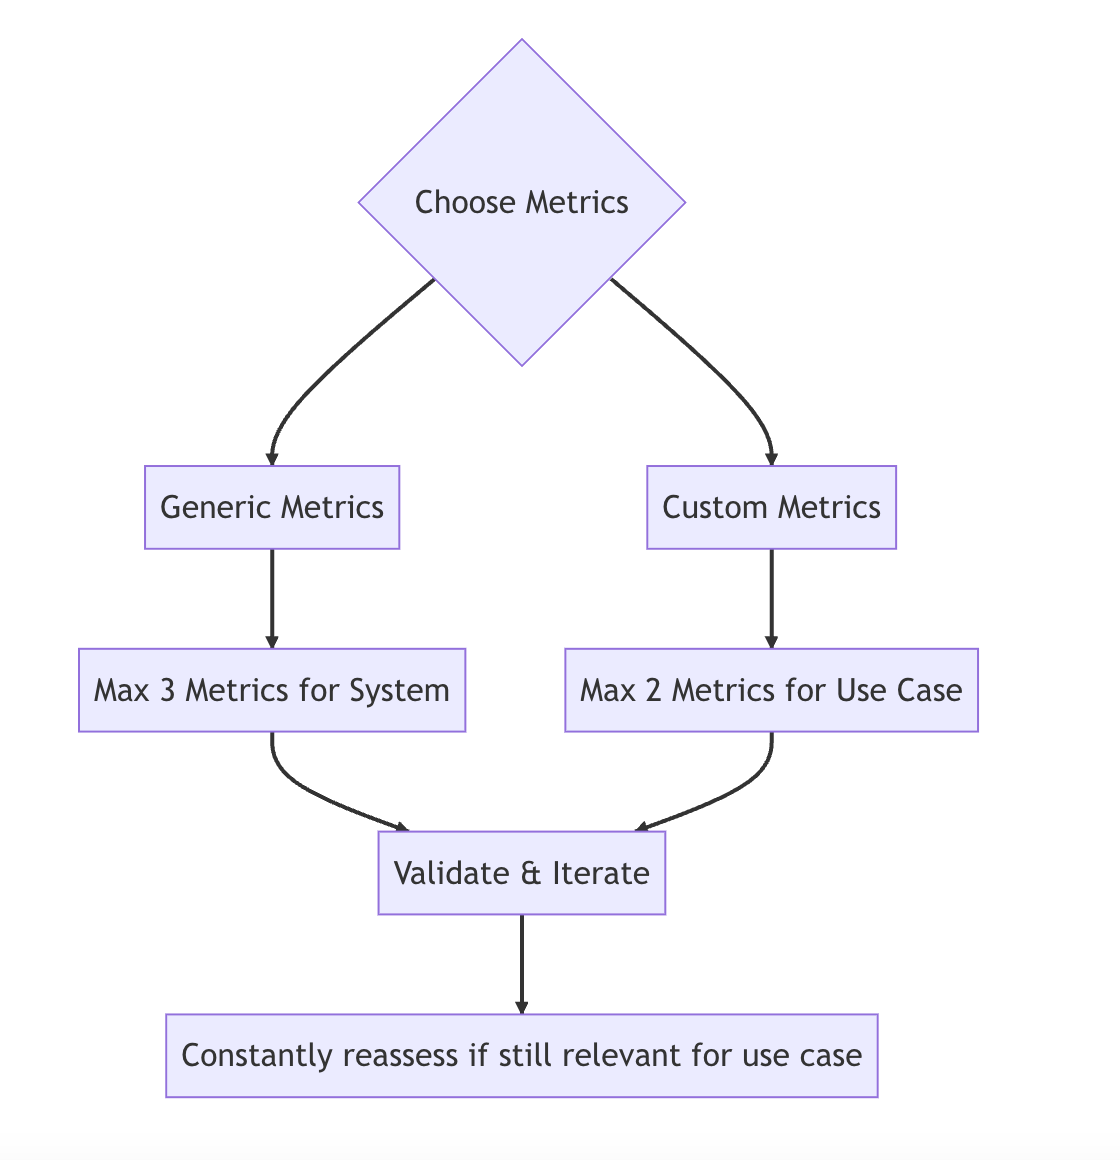

In [ ]:
from deepeval.metrics import AnswerRelevancyMetric, FaithfulnessMetric, ContextualRelevancyMetric

answer_relevancy_metric = AnswerRelevancyMetric(
    threshold=0.7, #
    model="gpt-4o",
    include_reason=True
)
faithfulness_metric = FaithfulnessMetric(
    threshold=0.7,
    model="gpt-4o",
    include_reason=True
)
contextual_relevancy_metric = ContextualRelevancyMetric(
    threshold=0.7,
    model="gpt-4o",
    include_reason=True
)

$$
Answer Relevancy = \frac{Total Number Of Statements}{Number Of Relevant Statements}
$$

$$
Faithfulness = \frac{Total Number Of Claims}{Number Of Truthful Claims}
$$

$$
Contextual Relevancy= \frac{Total Number Of Statements}{Number Of Relevant Statements}
$$

In [ ]:
answer_relevancy_metric.measure(test_case)
print(answer_relevancy_metric.score, answer_relevancy_metric.reason)

In [ ]:
faithfulness_metric.measure(test_case)
print(faithfulness_metric.score, faithfulness_metric.reason)

In [ ]:
contextual_relevancy_metric.measure(test_case)
print(contextual_relevancy_metric.score, contextual_relevancy_metric.reason)

In [ ]:
metrics = [answer_relevancy_metric, faithfulness_metric, contextual_relevancy_metric]

In [ ]:
faithfulness_metric.__name__

In [ ]:
scores = {}
for metric in metrics:
    metric.measure(test_case)
    scores[metric.__name__] = metric.score 

In [ ]:
pprint(scores)

In [ ]:
from deepeval import evaluate

evaluate(test_cases=[test_case], metrics=metrics)

## 2.3 Goldens

https://deepeval.com/docs/evaluation-datasets#what-are-goldens
<div>
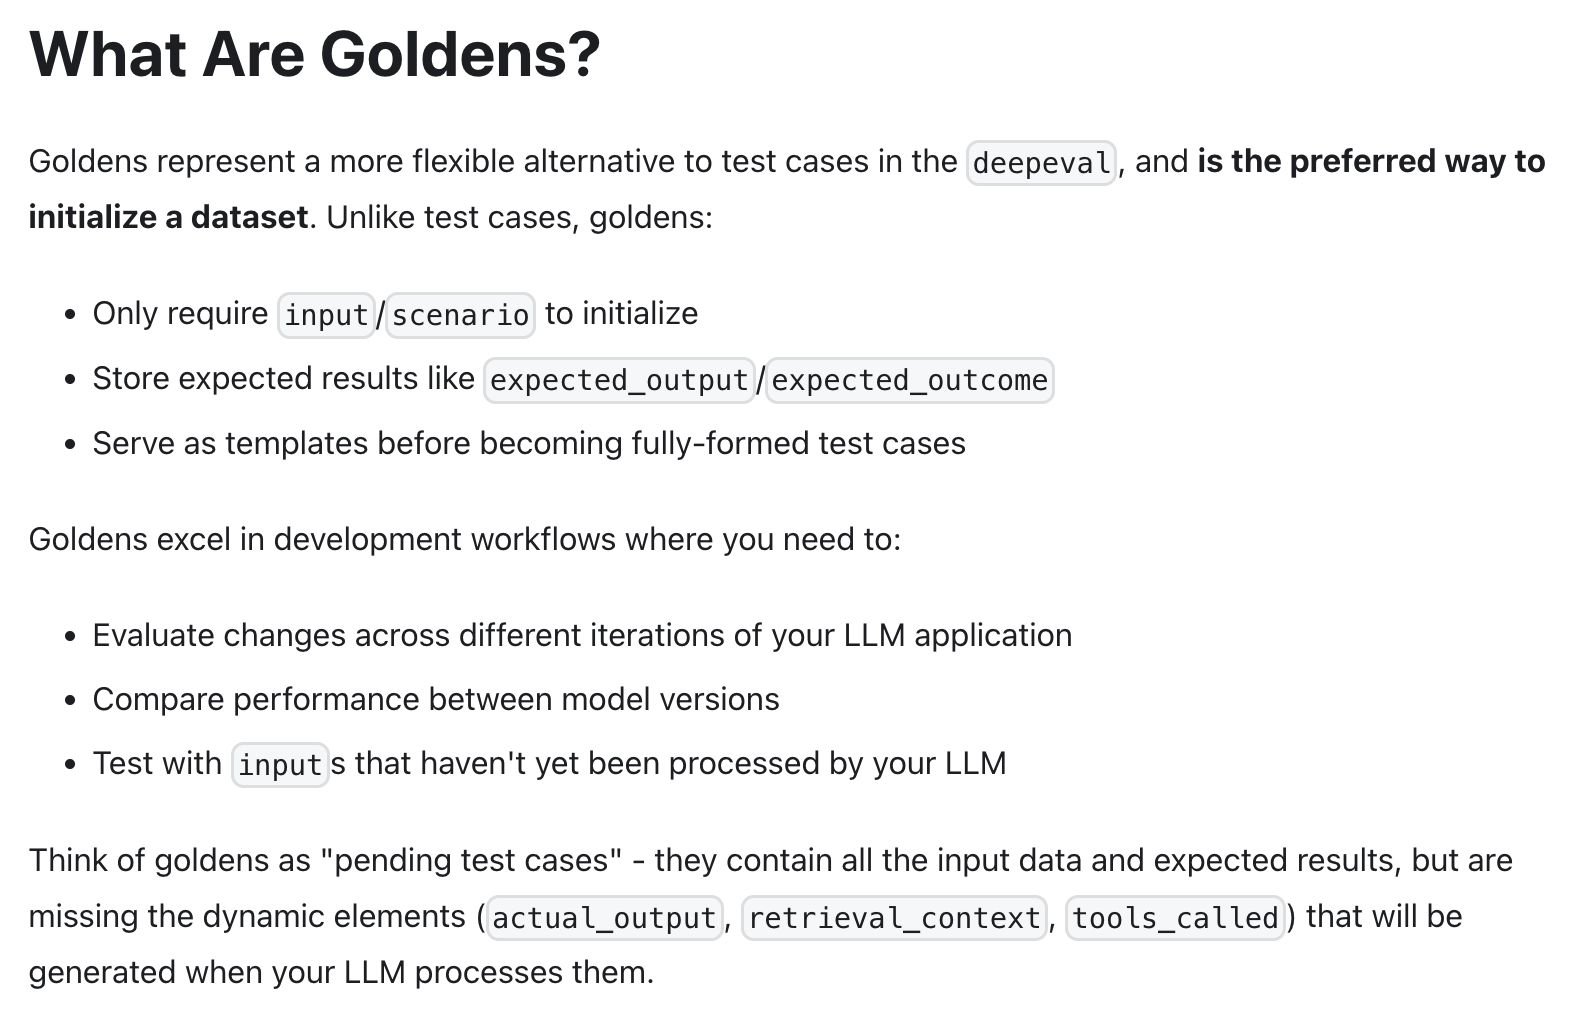
</div>


In [ ]:
from deepeval.dataset import Golden

goldens = [
    Golden(input="I have a cough, should I be worried?"),
    Golden(input="Symptoms of Covid?"),
    Golden(input="What are your top tips for fitness?"),
    Golden(input="How many elephants did Hannibal have?"),
    Golden(input="What were Scylla and Charybdis in the Odyssey?"),
    Golden(input="How many steps should I take a day?"),
    Golden(input="What are some ways to get more steps in on a day?"),
    Golden(input="What is a good resting heart rate?"),
    Golden(input="What range of heart rate is normal?")
]

## 2.4 Datasets
A dataset is a collection of "goldens" or test cases.

Findings:
- They make sense for batch evals.
- The results structure is very nested, you need to do alot of unpacking to get results in bulk.
- Every entry has to be a `LLMTestCase` or `Golden` -> this is quite annoying if you want to work with large arrays of data for example.

In [ ]:
from deepeval.dataset import EvaluationDataset, Golden

dataset = EvaluationDataset(
    goldens=goldens
)

In [ ]:
dataset

In [ ]:
for golden in dataset.goldens:
    test_case = LLMTestCase(
        input=golden.input,
        actual_output="Eh, no idea mate ...",#your_llm_app(golden.input) # replace with your LLM app
        retrieval_context=["Daily Mail pg 7"]
    )
    dataset.add_test_case(test_case)

In [ ]:
dataset.test_cases

In [ ]:
results = evaluate(test_cases=dataset.test_cases, metrics=metrics)

In [ ]:
results

In [ ]:
# Process results dataset into something readable
import pandas as pd
import json

def reformat_results(results: EvaluationDataset) -> pd.DataFrame:
    data = json.loads(results.model_dump_json())
    df = pd.json_normalize(
        data,
        record_path=["test_results", "metrics_data"],
        meta=[["test_results", "name"]],
    )
    # Rename and pivot to wide format
    df = df.pivot(
        index="test_results.name",
        columns="name",
        values="score"
    ).reset_index()
    # Optional: rename columns for clarity
    df.columns.name = None
    df = df.rename(columns=lambda x: "test_case" if x == "test_results.name" else f"{x}_value")
    return df

In [ ]:
df = reformat_results(results)

In [ ]:
df

# 3. RAG Agent
Example adapted from https://github.com/confident-ai/deepeval/blob/main/examples/notebooks/langgraph.ipynb

<div>
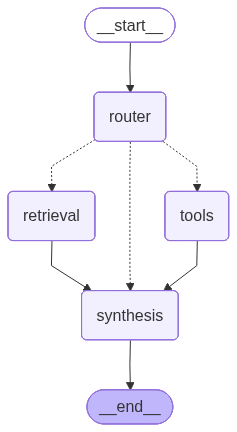
</div>

In [ ]:
# !curl -o src/manual.txt "https://confident-bucket.s3.us-east-1.amazonaws.com/manual.txt"

In [ ]:
from src.langgraph_rag_agent import app
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage

initial_state = {
    "query": "",
    "selected_tools": [],
    "retrieved_context": "",
    "tool_outputs": [],
    "next_action": "",
}

def rag_query(query: str):
    """Run a query through the RAG system"""

    state = {"messages": [HumanMessage(content=query)]}
    result = app.invoke(state)
    return {
        "response": result["messages"][-1].content,
        "retrieved_context": result.get("retrieved_context", ""),
        "route": result.get("next_action", ""),
        "tool_outputs": result.get("tool_outputs", []),
    }

In [ ]:
rag_query("What is the average heart rate of the user?")

In [ ]:
rag_query("What are your top tips for fitness?")

In [ ]:
rag_dataset = EvaluationDataset(
    goldens=goldens #same ones as before
)

In [ ]:
for golden in rag_dataset.goldens[0:2]:
    output = rag_query(golden.input) #generate some real outputs, might take a while...
    test_case = LLMTestCase(
        input=golden.input,
        actual_output=output['response'], # replace with your LLM app
        retrieval_context=[output['retrieved_context']] # current setup this is returned as a single string.
    )
    rag_dataset.add_test_case(test_case)

In [ ]:
rag_results = evaluate(rag_dataset.test_cases, metrics=metrics)

In [ ]:
df_rag = reformat_results(rag_results)

In [ ]:
df_rag

# 4. Execution (More Examples)

## 4.1 Unit Tests

In [ ]:
from deepeval import assert_test
from deepeval.test_case import LLMTestCase, LLMTestCaseParams
from deepeval.metrics import GEval

def test_correctness():
    correctness_metric = GEval(
        name="Correctness",
        criteria="Determine if the 'actual output' is correct based on the 'expected output'.",
        evaluation_params=[LLMTestCaseParams.ACTUAL_OUTPUT, LLMTestCaseParams.EXPECTED_OUTPUT],
        threshold=0.5
    )
    test_case = LLMTestCase(
        input="I have a persistent cough and fever. Should I be worried?",
        # Replace this with the actual output from your LLM application
        actual_output="A persistent cough and fever could be a viral infection or something more serious. See a doctor if symptoms worsen or don't improve in a few days.",
        expected_output="A persistent cough and fever could indicate a range of illnesses, from a mild viral infection to more serious conditions like pneumonia or COVID-19. You should seek medical attention if your symptoms worsen, persist for more than a few days, or are accompanied by difficulty breathing, chest pain, or other concerning signs."
    )
    assert_test(test_case, [correctness_metric])

In [ ]:
!deepeval test run src/test_basic.py

In [ ]:
%%skip
from deepeval import assert_test
from deepeval.dataset import EvaluationDataset, Golden
from deepeval.test_case import LLMTestCase
from deepeval.metrics import AnswerRelevancyMetric
...

dataset = EvaluationDataset(goldens=[...])
for goldens in dataset.goldens:
  dataset.add_test_case(...) # convert golden to test case

@pytest.mark.parametrize(
    "test_case",
    dataset.test_cases,
)
def test_rag(test_case: LLMTestCase):
    # metrics is the list of RAG metrics as shown in previous sections
    assert_test(test_case, metrics)

## 4.2 Callback Handler
If you are on Confident-AI, but you need a corporate email ... BOO!

In [ ]:
%%skip
from deepeval.integrations.langchain import CallbackHandler
from deepeval.metrics import TaskCompletionMetric


def run_rag_query(query: str):
    """Run a query through the RAG system"""

    initial_state["messages"] = [HumanMessage(content=query)]

    result = app.invoke(
        initial_state,
        config={
            "callbacks": [
                CallbackHandler(
                    metrics=[
                        TaskCompletionMetric(strict_mode=True, async_mode=False)
                    ]
                )
            ]  # pass the metrics to the callback handler
        },
    )

    final_message = result["messages"][-1]
    return final_message.content


## 4.3 Batch
You can schedule these eval runs as part of an online eval/monitoring monitoring pipeline.

<div>
<img src="deepeval-airflow.svg" width="600"/>
</div>

# 5. Tracing (Bonus)

In [ ]:
%%skip
from deepeval.tracing import observe

@observe()
def your_ai_agent_tool():
    return 'tool call result'

@observe()
def your_ai_agent(input):
    tool_call_result = your_ai_agent_tool()
    return 'Tool Call Result: ' + tool_call_result

your_ai_agent("Greetings, AI Agent.")

# 6. Agents (Bonus)
<em> When you call dataset.evals_iterator(), deepeval starts a "test run"
As you loop through your dataset, deepeval collects your agents' LLM traces and runs task completion on them.
Each task completion metric will be ran once per loop, creating a test case
In the end, you will have the same number of test cases in your test run as goldens in the dataset you ran evals with.</em>

## 6.1 Agents - E2E

In [ ]:
%%skip
from eepeval.integrations.langchain import CallbackHandler
from langgraph.prebuilt import create_react_agent
from deepeval.dataset import EvaluationDataset, Golden
...

def get_weather(city: str) -> str:
    """Returns the weather in a city"""
    return f"It's always sunny in {city}!"

agent = create_react_agent(
    model="openai:gpt-4.1",
    tools=[get_weather],
    prompt="You are a helpful assistant",
)

# Create dataset
dataset = EvaluationDataset(goldens=[Golden(input="Explain the latest trends in AI.")])

# Loop through dataset
for golden in dataset.evals_iterator():
    agent.invoke(
        input={"messages": [{"role": "user", "content": golden.input}]},
        # Supply task completion
        config={"callbacks": [CallbackHandler(metrics=[task_completion_metric])]},
    )

## 6.2 Agents - Component Level

In [ ]:
%%skip
from openai import OpenAI
import json
from deepeval.test_case import LLMTestCase, ToolCall
from deepeval.tracing import observe, update_current_span
...

client = OpenAI()
tools = [...]

@observe()
def web_search_tool(web_query):
    return "Web search results"

# Supply metric
@observe(metrics=[arg_correctness_metric])
def llm_component(query):
    response = client.responses.create(model="gpt-4.1", input=[{"role": "user", "content": query}], tools=tools)

    # Format tools
    tools_called = [ToolCall(name=tool_call.name, arguments=tool_call.arguments) for tool_call in response.output if tool_call.type == "function_call"]

    # Create test cases on the component-level
    update_current_span(
        test_case=LLMTestCase(input=query, actual_output=response.output_text, tools_called=tools_called)
    )
    return response.output

# Supply metric
@observe(metrics=[task_completion_metric])
def your_ai_agent(query: str) -> str:
    llm_output = llm_component(query)
    search_results = "".join([web_search_tool(**json.loads(tool_call.arguments)) for tool_call in llm_output if tool_call == "function_call"])
    return "The answer to your question is: " + search_results